In [1]:
# Importando las librerias básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Código usado para importar datos a google colab
from google.colab import files
files.upload()

In [3]:
# Cargando el archivo importado, viendo las dos primeras instancias
# sus dimensiones y el tipo de datos que contiene
data_raw=pd.read_csv("heart.csv")
print(data_raw.head(2).to_string())
print("Las dimensiones del dataset son", data_raw.shape)
print(data_raw.dtypes)
# Se verifico que la data era balanceada

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease
0   40   M           ATA        140          289          0     Normal    172              N      0.0       Up             0
1   49   F           NAP        160          180          0     Normal    156              N      1.0     Flat             1
Las dimensiones del dataset son (918, 12)
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


In [4]:
# Separammos las variables numericas de las no numericas categorical
cols = data_raw.columns
num_cols = data_raw._get_numeric_data().columns
num_cols
cat_cols=list(set(cols) - set(num_cols))
print("Numerical features", num_cols)
print("Non-numerical features", cat_cols)

Numerical features Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')
Non-numerical features ['ChestPainType', 'ExerciseAngina', 'ST_Slope', 'RestingECG', 'Sex']


               Age  Sex ChestPainType   RestingBP  Cholesterol   FastingBS RestingECG       MaxHR ExerciseAngina     Oldpeak ST_Slope  HeartDisease
count   918.000000  918           918  918.000000   918.000000  918.000000        918  918.000000            918  918.000000      918    918.000000
unique         NaN    2             4         NaN          NaN         NaN          3         NaN              2         NaN        3           NaN
top            NaN    M           ASY         NaN          NaN         NaN     Normal         NaN              N         NaN     Flat           NaN
freq           NaN  725           496         NaN          NaN         NaN        552         NaN            547         NaN      460           NaN
mean     53.510893  NaN           NaN  132.396514   198.799564    0.233115        NaN  136.809368            NaN    0.887364      NaN      0.553377
std       9.432617  NaN           NaN   18.514154   109.384145    0.423046        NaN   25.460334            NaN

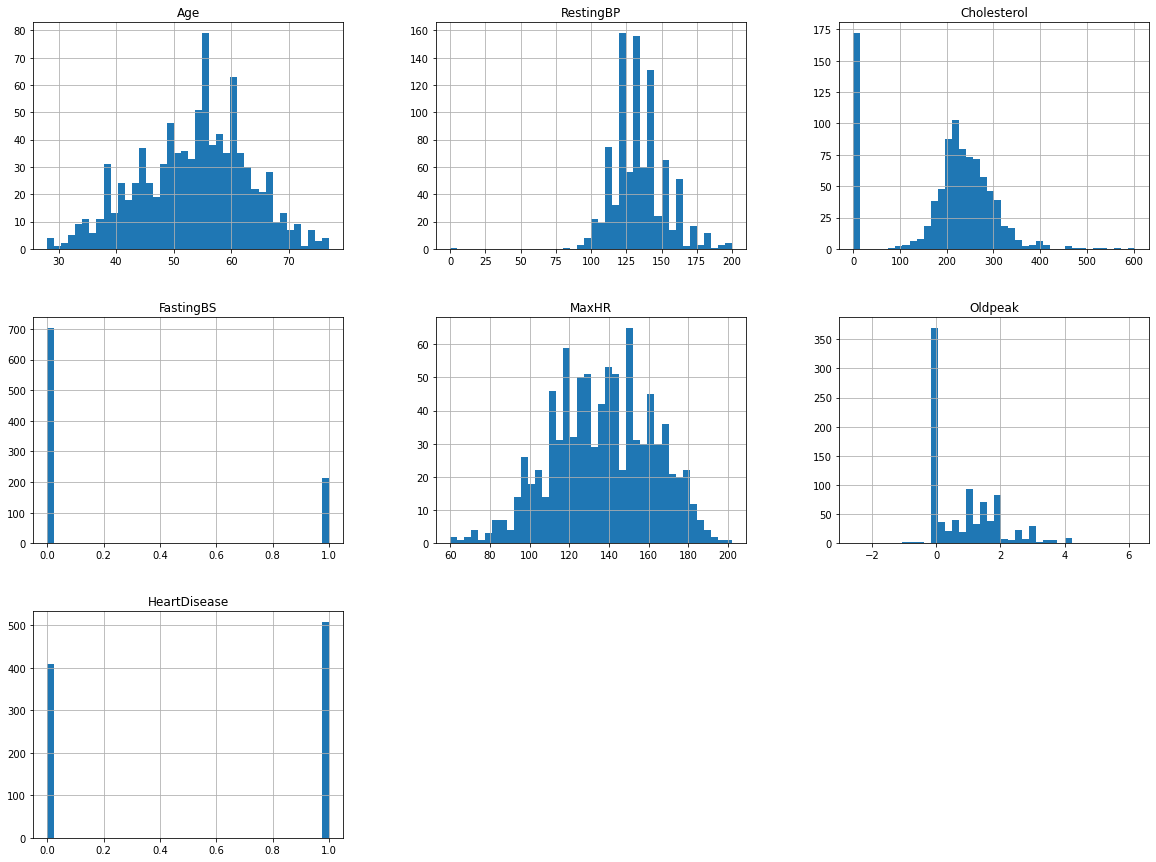

In [5]:
# Previsualización de variables numericas a través de histogramas
# además obtenemos estadisticos de cada variable ya sea numerica o no
data_raw[num_cols].hist(bins=40, figsize=(20,15))
print(data_raw.describe(include="all").to_string())

In [6]:
# para la data no numerica obtenemes la frecuencia de valores comunes.
for i in range(len(cat_cols)):
  print(data_raw[cat_cols[i]].value_counts())

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64
N    547
Y    371
Name: ExerciseAngina, dtype: int64
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64
M    725
F    193
Name: Sex, dtype: int64


In [7]:
# Realizamos un LabelEncoder para convertir las variables no numericas
# en numericas y poder trabajar con el algoritmo de RFC
df=data_raw.copy()
from sklearn.preprocessing import LabelEncoder
for c in df.columns:
    if df[c].dtype=='object':
        df[c] = df[c].fillna('NAN')
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(df[c].values)
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0


In [ ]:
# Como observamos anteriormente en los datos de colesterol se encontraba un grupo
# atípico así que revisaremos sus caracteristicas
print(df[df['Cholesterol']<70]['Cholesterol'].nunique())
df[df['Cholesterol']<70].describe()
# Se encontró que los valores eran 0, no corresponden con valores reales por lo que 
# se asume que se trataron de valores perdidos.

# De igual forma en Oldpeak se encuentran algunos datos negativos que pueden
# ser eliminados
print(df[df['Oldpeak']<0]['Oldpeak'].nunique())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000
mean,52.943089,0.756098,0.840108,133.111111,242.138211,0.166667,0.930894,140.239837,0.386179,0.906640,1.411924,0.475610
std,9.471489,0.429726,0.958524,17.322188,52.736022,0.372931,0.633180,24.620059,0.487203,1.075657,0.599384,0.499743
min,28.000000,0.000000,0.000000,92.000000,85.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,1.000000,0.000000,120.000000,207.000000,0.000000,1.000000,122.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,1.000000,130.000000,237.000000,0.000000,1.000000,140.000000,0.000000,0.500000,1.000000,0.000000
75%,59.000000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,160.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,458.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


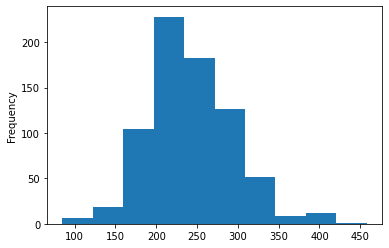

In [9]:
# Como los valores representaban menos del 20% de la data y aún eliminandolos
# tendriamos un volumen considerable para trabajar, aquí se elimina ese grupo
df=df[df['Cholesterol']>70]
df=df[df['Cholesterol']<466]
# Similar para el caso de Oldpeak valores negativos parecen no tener un significado
# médico real por lo que se consideran outliers y se eliminan (son solo 13 datos).
df=df[df['Oldpeak']>=0]
# Revisamos que ahora los datos de cholesterol cumplen una distribucion normal
df["Cholesterol"].plot.hist()
df.describe()

In [10]:
# Separamos la data en dos grupos disease y no disease y obtenemos valores estadisticos.
disease=df[df["HeartDisease"]==1]
notdisease=df[df["HeartDisease"]==0]
print("Heart disease data \n"  + disease.describe().to_string())
print()
print("No Heart disease data \n"  +notdisease.describe().to_string())

Heart disease data 
              Age         Sex  ChestPainType   RestingBP  Cholesterol  FastingBS  RestingECG       MaxHR  ExerciseAngina     Oldpeak    ST_Slope  HeartDisease
count  351.000000  351.000000     351.000000  351.000000   351.000000  351.00000  351.000000  351.000000      351.000000  351.000000  351.000000         351.0
mean    56.011396    0.886040       0.444444  136.247863   247.210826    0.22792    0.937322  130.495726        0.669516    1.472934    1.037037           1.0
std      8.724343    0.318216       0.872872   18.034842    53.551695    0.42009    0.689971   22.425479        0.471059    1.148033    0.467573           0.0
min     31.000000    0.000000       0.000000   92.000000   100.000000    0.00000    0.000000   71.000000        0.000000    0.000000    0.000000           1.0
25%     50.000000    1.000000       0.000000  124.000000   212.000000    0.00000    0.000000  115.000000        0.000000    0.600000    1.000000           1.0
50%     57.000000    1.000

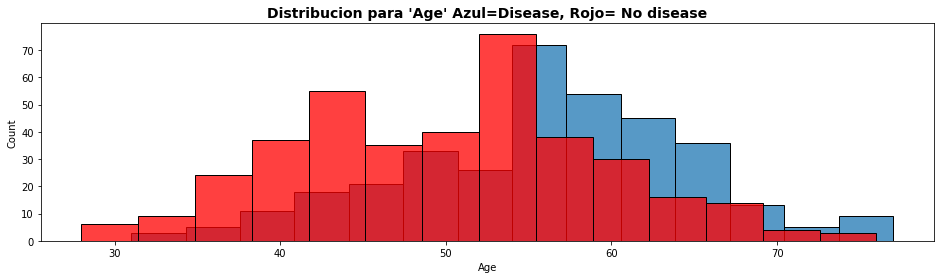

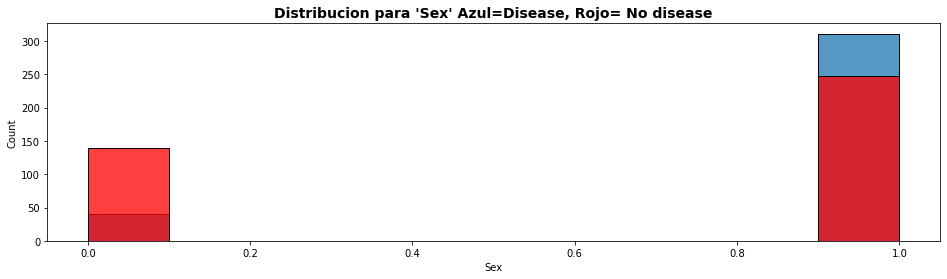

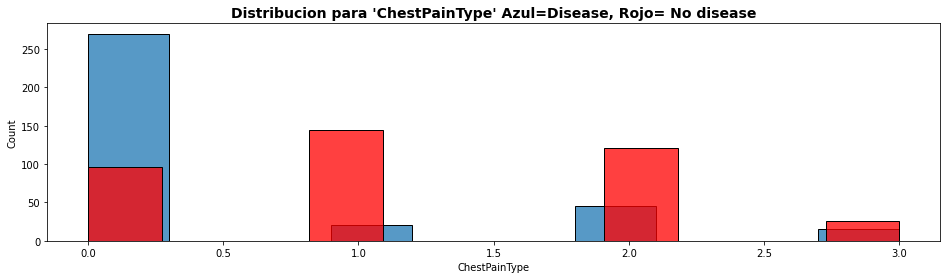

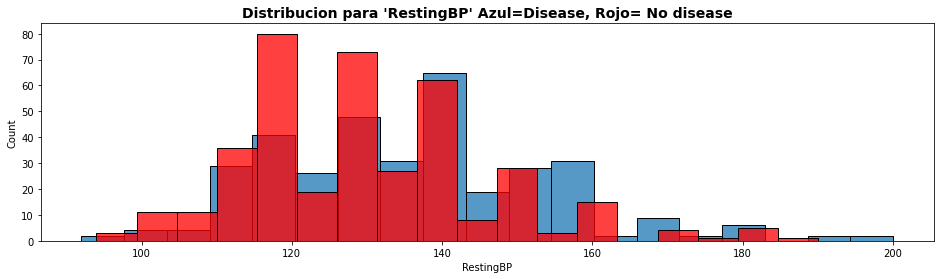

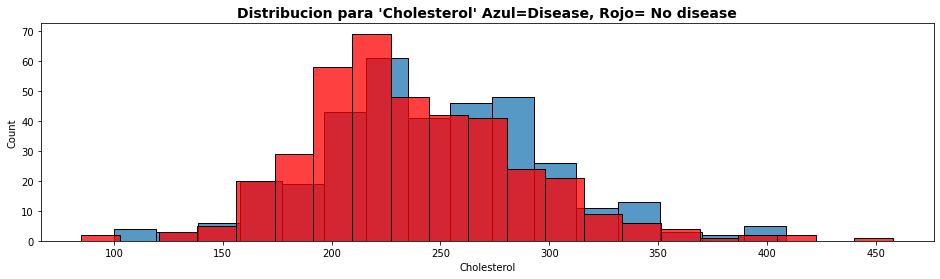

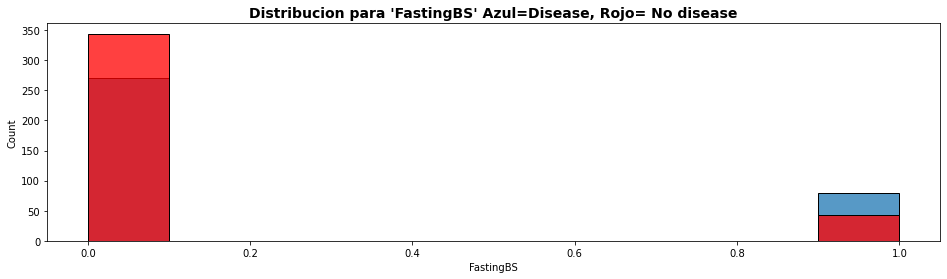

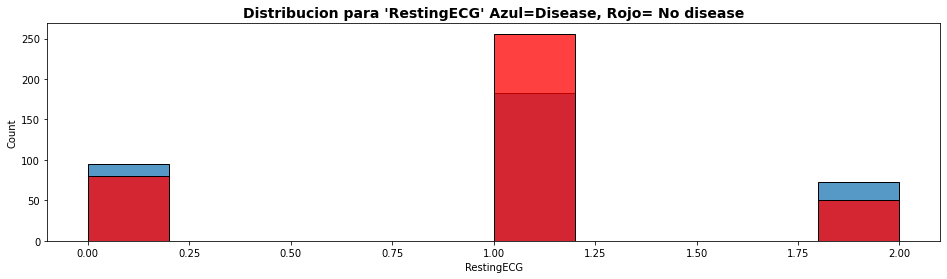

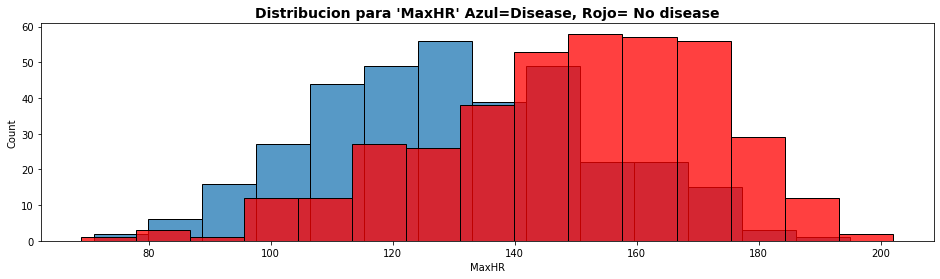

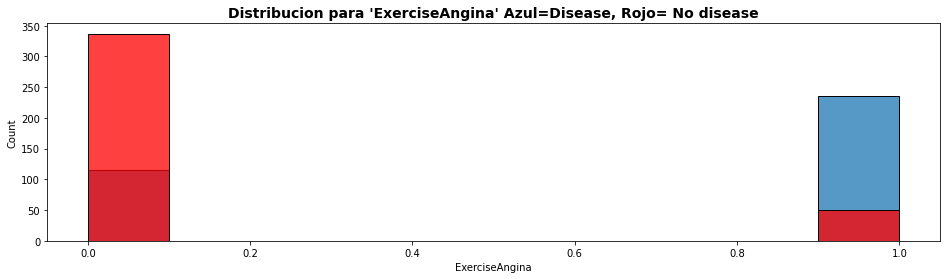

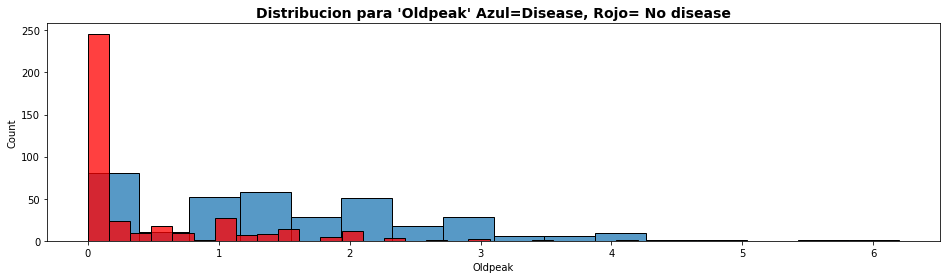

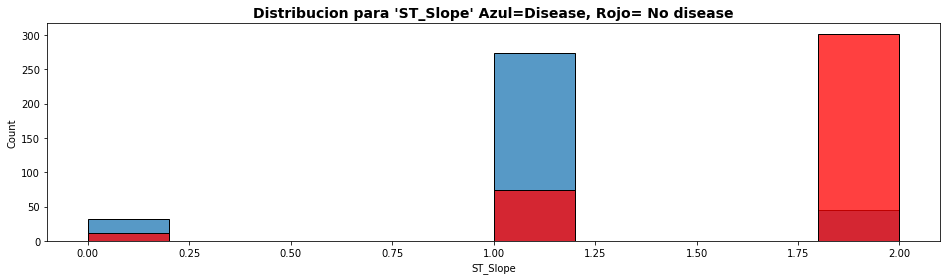

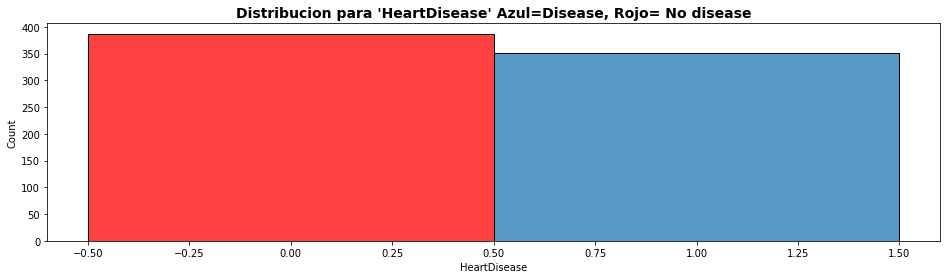

In [18]:
# Se realiza nuevamente una visualización de histogramas 
# para cada grupo anterior
for c in df.columns:
    plt.figure(figsize=(16,4))
    ax = sns.histplot(disease[c])
    ax = sns.histplot(notdisease[c],color="red")
    ax.set_title(f"Distribucion para '{c}' Azul=Disease, Rojo= No disease",size=14, fontweight='bold')
    plt.show()

In [19]:
# Seleccionamos la data para entrenar el modelo
y=df["HeartDisease"]
x=df[ ["Age","ChestPainType","RestingBP","Cholesterol","FastingBS",            \
       "RestingECG","MaxHR", "Oldpeak","ST_Slope","ExerciseAngina","Sex"] ]
# Nota : Otro grupo de variables que presentaron resultados favorables en 
# el entrenamiento del algoritmo fueron
# ["ChestPainType","MaxHR","ExerciseAngina","ST_Slope","Cholesterol","Oldpeak"]

In [35]:
# Separamos la data en data de entrenamiento y de validacion (test)
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, precision_score
X_train, X_test, y_train, y_test = tts(x , y, test_size=0.2)

In [36]:
# Train the algorithm
# El procedimiento para optimizar parámetros del modelo se realizó por fuerza bruta
# no se incluye de forma explicita el código aquí, se encontró que un valor
# adecuado para el numero de estimadores era de 200
# En cuanto al criterio del algoritmo se probaron el criterio de entropia y gini
# no encontrando diferencias significativas entre ambos.
algoritmo=RFC(n_estimators=200, criterion ="entropy")
algoritmo.fit(X_train, y_train)
# Realizamos una predicción
y_pred= algoritmo.predict(X_test)
# Realizamos la validación y un plot de la matriz de confusion,
# la diagonal son los valores acertados por la prediccion y la antidiagonal los errores.
matriz= confusion_matrix(y_test, y_pred)
print("\n matriz de confusión\n")
print(matriz)
score= precision_score(y_test,y_pred)
print("\n presicion del modelo \n", score)


 matriz de confusión

[[70  8]
 [11 59]]

 presicion del modelo 
 0.8805970149253731
